In [28]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime, timezone, timedelta
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import linregress
import itertools

In [32]:
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 4)

testing 15m, len(records) = 250
2023-10-27 14:57:11.760000
        timestamp  signal  pnl
56  1699614118752  0.0206 -1.0
57  1699614118779  0.0172 -1.0
58  1699614118808  0.0121 -1.0
59  1699614118835  0.0315 -1.0
60  1699614118938  0.0187 -1.0
61
slope: 2.18216, mean pnl: 0.06343


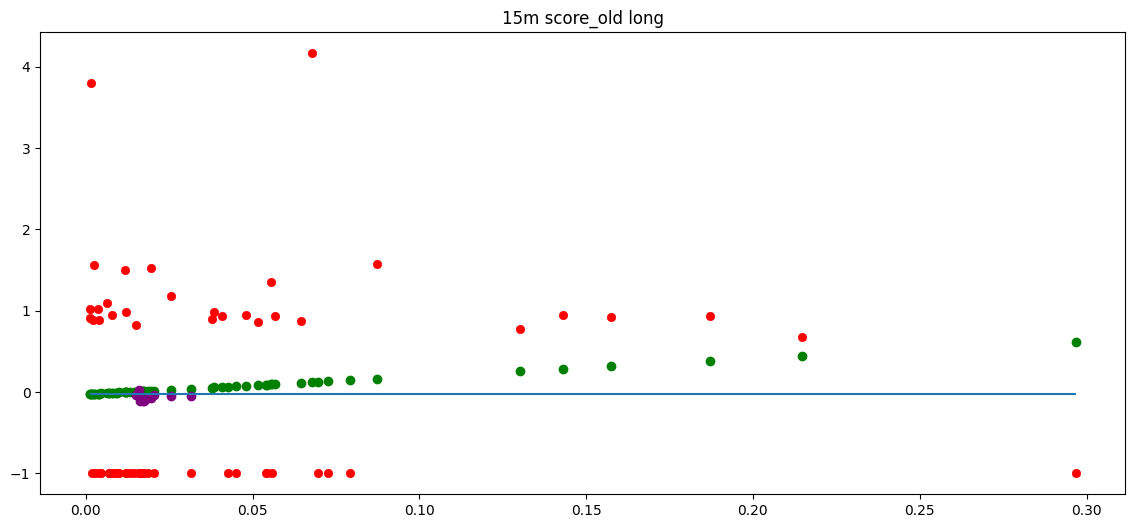

testing 15m, len(records) = 250
2023-10-27 14:57:12.002000
         timestamp  signal    pnl
183  1699614118913  0.0907 -1.000
184  1699614118972  0.1080  4.689
185  1699614118999  0.4792  4.754
186  1699614119022  0.0641  5.123
187  1699614119167  0.1417  5.521
188
slope: 0.00826, mean pnl: 0.03647


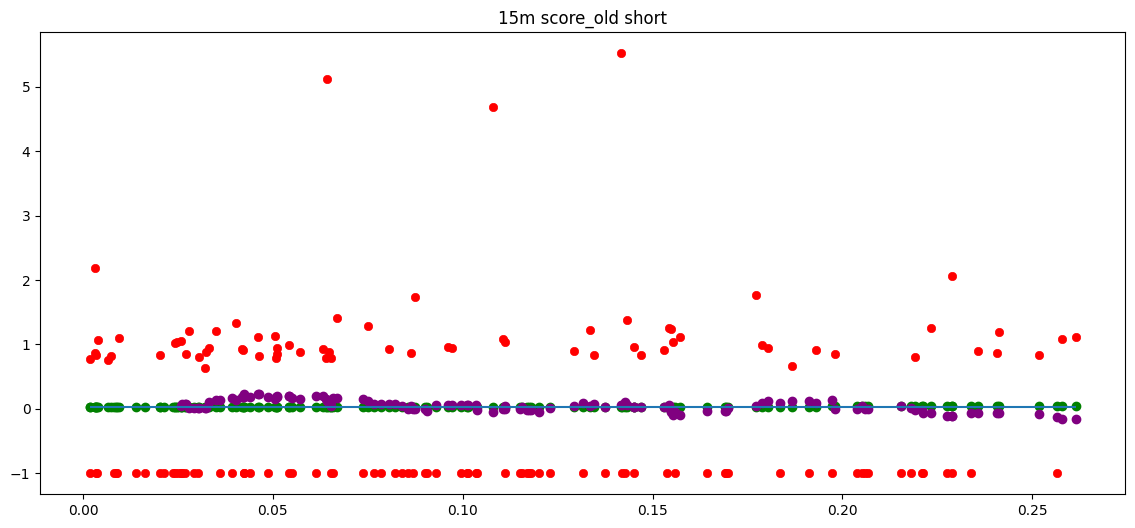

testing 30m, len(records) = 124
2023-10-27 14:57:12.171000
        timestamp  signal    pnl
13  1699378411706  0.0125 -1.000
14  1699385446172  0.1467  0.740
15  1699436046276  0.0362  0.849
16  1699614119244  0.0798 -1.000
17  1699614119275  0.0550 -1.000
18
slope: 8.60481, mean pnl: 0.18761


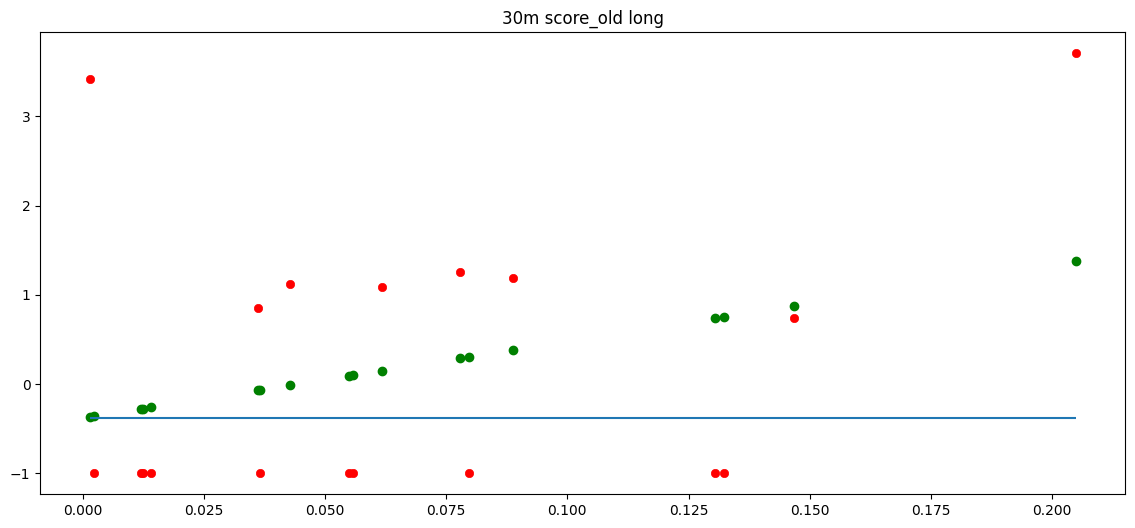

testing 30m, len(records) = 124
2023-10-27 14:57:12.352000
         timestamp  signal    pnl
101  1699614119282  0.0342 -1.000
102  1699614119289  0.4542 -1.000
103  1699614119295  0.1791  8.027
104  1699614119301  0.1743 -1.000
105  1699614119307  0.3828 -1.000
106
slope: -0.55535, mean pnl: -0.10719


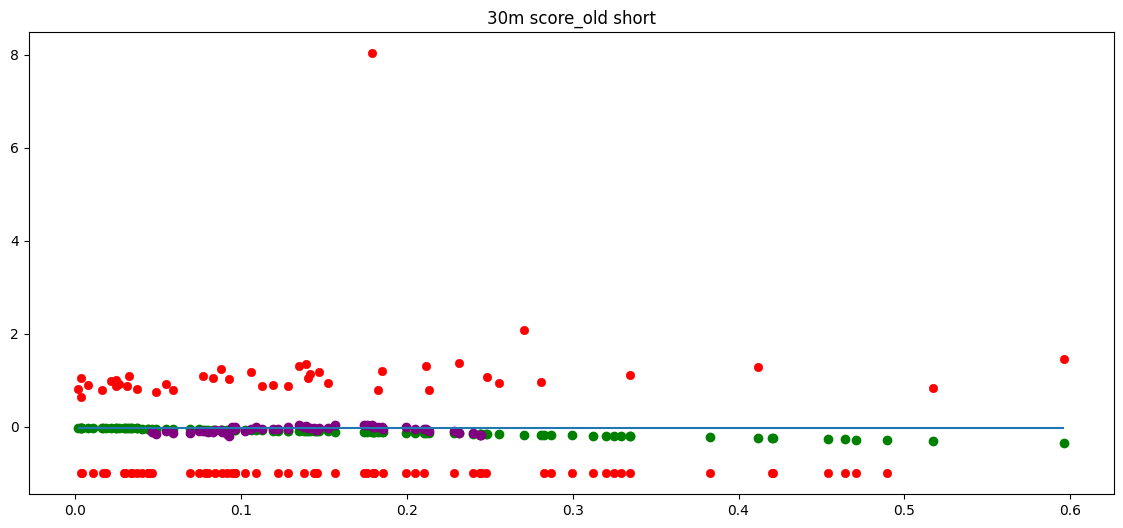

testing 1h, len(records) = 80
2023-10-27 14:57:12.494000
       timestamp  signal    pnl
0  1699365937517  0.0208  0.984
1  1699420110542  0.0053  1.135
2  1699423723209  0.0067  1.156
3  1699614121992  0.0030 -1.000
4  1699614122015  0.0272 -1.000
5
slope: -25.95857, mean pnl: 0.25500


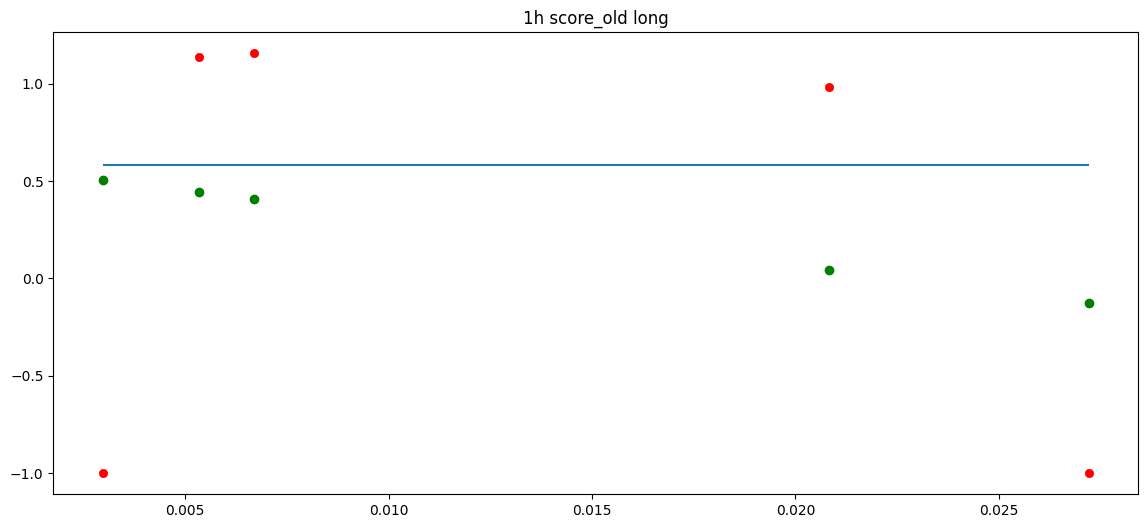

testing 1h, len(records) = 80
2023-10-27 14:57:12.671000
        timestamp  signal    pnl
69  1699614122184  0.0668 -1.000
70  1699614122196  0.0753 -1.000
71  1699614122208  0.2354 -1.000
72  1699614122244  0.1821 -1.000
73  1699614155088  0.0395  1.115
74
slope: -0.16969, mean pnl: -0.22834


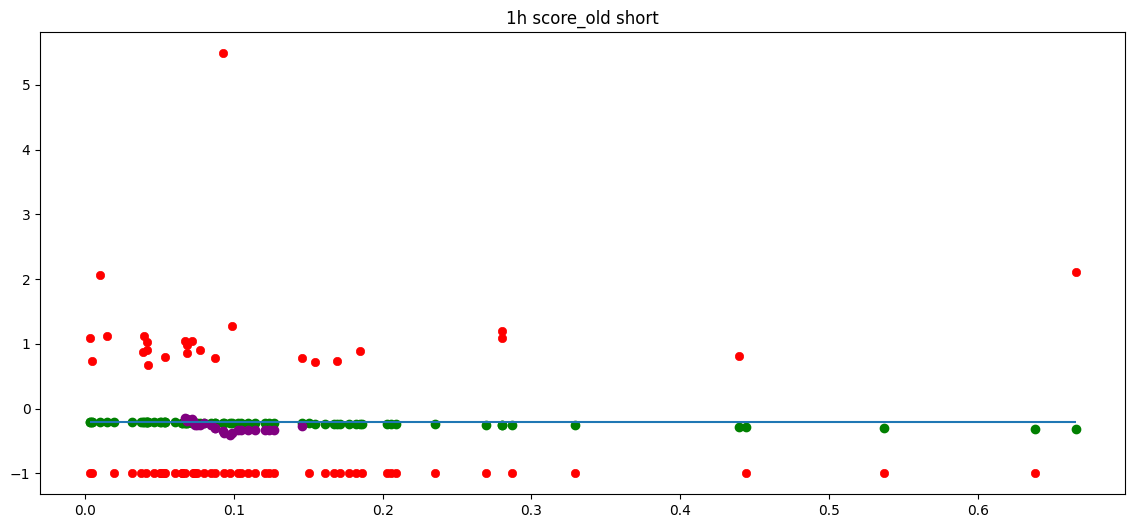

testing 4h, len(records) = 35
2023-10-27 14:57:12.835000


AttributeError: 'DataFrame' object has no attribute 'timestamp'

In [51]:
# tf = '15m'
for tf, direction in itertools.product(['15m', '30m', '1h', '4h', '12h', '1d'], ['long', 'short']):
    records = {}
    
    try:
        strats = [
            f'ChannelRun_{tf}_None_200_edge_1w_volumes_50', f'ChannelRun_{tf}_None_200_mid_1w_volumes_50',
            # f'trail_fractals_{tf}_None_5_2_1d_volumes_30', f'trail_fractals_{tf}_None_5_2_1w_volumes_30'
        ]
        for strat in strats:
            records_path = Path(f'/home/ross/coding/modular_trader/records/{strat}/closed_sim_trades.json')
            with open(records_path, 'r') as file:
                records.update(json.load(file))
    except FileNotFoundError:
        continue
    print(f"testing {tf}, {len(records) = }")
    
    now = int(datetime.now(tz=timezone.utc).timestamp() * 1000)
    before = now - (60 * 60 * 24 * 7 * 2 * 1000)
    print(datetime.fromtimestamp(before / 1000))
    # pprint(records)
    records = {k: v for k, v in records.items() if v['signal'].get('score_old')}# and int(k) > before}
    key = 'score_old'
    try:
        a = [{'timestamp': k, 
              'signal': float(v['signal'][key]), 
              'pnl': v['trade'][-1]['rpnl']
              } for k, v in records.items()
             if (v['signal'].get('score_old')) 
             and (v['signal']['direction'] == direction)
             ]
    except KeyError:
        continue
        
    df = pd.DataFrame(a)
    df.timestamp = df.timestamp.astype('int')
    df = df.sort_values('timestamp')
    df = df.loc[df.timestamp > before]
    df = df.sort_values('signal')
    df['avg'] = df.pnl.rolling(50, center=True).mean()
    linreg = linregress(df.signal, df.pnl)
    print(f"slope: {linreg.slope:.5f}, mean pnl: {df.pnl.mean():.5f}")
    df['lin_reg'] = (df.signal * linreg.slope) + linreg.intercept
    df = df.head(150)
    
    plt.figure(figsize=(14, 6))
    # plt.hist(df.signal, density=False, weights=df.pnl)
    plt.scatter(df.signal, df.pnl, c='red', linewidths=0.5)
    plt.scatter(df.signal, df.lin_reg, c='green')
    plt.scatter(df.signal, df.avg, c='purple')
    plt.hlines(linreg.intercept, xmin=df.signal.min(), xmax=df.signal.max())
    plt.title(f"{tf} {key} {direction}")
    # plt.xscale('log')
    plt.show()

# TODO if rr is calculated to be 10/20/30, why are trades closing with 1/2/4 R pnl? surely they should all close with either -1 or their originally calculated rr. needs to be investigated

conf_rf_usdt_l
conf_rf_usdt_s
market_rank_1d: cr 1h short +
market_rank_1w
market_rank_1m: cr 1h short +
inval_dist

channel run 15m longs incline with the 1d and decline with the 1w and 1m mkt ranks, ideal rr ~6.1
channel run 15m shorts incline with conf_rf_usdt_l
channel run 15m longs and shorts incline with inval_dist

channel run 30m
channel run 1h shorts incline with 1d and 1m mkt ranks
channel run 4h shorts incline with all 3 mkt ranks

In [43]:
pprint(records)

{'1699166988022': {'signal': {'action': 'open',
                              'agent': 'ChannelRun_15m_None_200_1w_volumes_50',
                              'asset': 'TRX',
                              'base_size': 68.60346063274291,
                              'bias': 'bullish',
                              'channel_position': 0.04266666666666505,
                              'conf_rf_usdt_l': 0.7997267927200125,
                              'conf_rf_usdt_s': 0.9927007299270073,
                              'confidence_l': 0.7997267927200125,
                              'confidence_s': 0.9927007299270073,
                              'direction': 'long',
                              'inval': 0.09711764196180364,
                              'inval_dist': 0.005146056527313636,
                              'inval_ratio': 0.9948539434726864,
                              'lookback': 200,
                              'market_rank_1d': 0.7393767705382436,
                   